# Distribution of Patch Count & Invalid Pixels Check

## Katy Koenig
### July 2019

In [40]:
%matplotlib inline
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from pyhdf.SD import SD, SDC
import prg_StatsInvPixel as stats

Read in csv and group by MOD02 files

In [2]:
df = pd.read_csv('output07102019.csv')
df['fraction_invalid'] = df['inval_pixels'] / 98403
grouped = df.groupby('filename') \
            .agg({'patch_no': 'count', 'inval_pixels':'sum'}).reset_index() \
            .rename(columns={'inval_pixels': 'sum_invalid_pixels', 'patch_no': 'patch_count'})

In [3]:
grouped.shape

(14511, 3)

In [4]:
grouped.head()

,filename,patch_count,sum_invalid_pixels
0,MOD021KM.A2000260.0000.061.2017175004738.hdf,120,1018
1,MOD021KM.A2000260.0005.061.2017175004931.hdf,76,15
2,MOD021KM.A2000260.0010.061.2017175004603.hdf,78,391
3,MOD021KM.A2000260.0015.061.2017175004552.hdf,137,247
4,MOD021KM.A2000260.0020.061.2017175004526.hdf,19,3293


In [5]:
df.describe()

,patch_no,inval_pixels,fraction_invalid
count,1.547438e+06,1.547438e+06,1.547438e+06
mean,5.803756e+01,2.605750e+02,2.648040e-03
std,3.783482e+01,8.228332e+02,8.361871e-03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.600000e+01,0.000000e+00,0.000000e+00
50%,5.400000e+01,0.000000e+00,0.000000e+00
75%,8.700000e+01,0.000000e+00,0.000000e+00
max,1.580000e+02,8.192000e+04,8.324949e-01


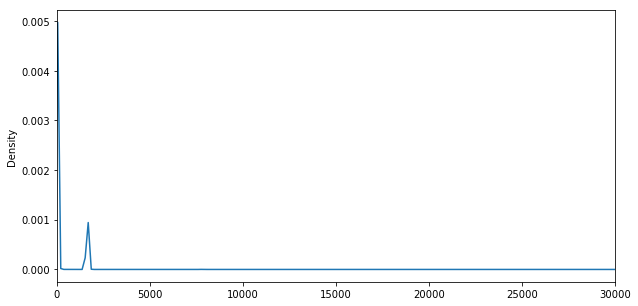

In [6]:
df['inval_pixels'].plot(kind='kde', xlim=(0, 30000), figsize=(10, 5))

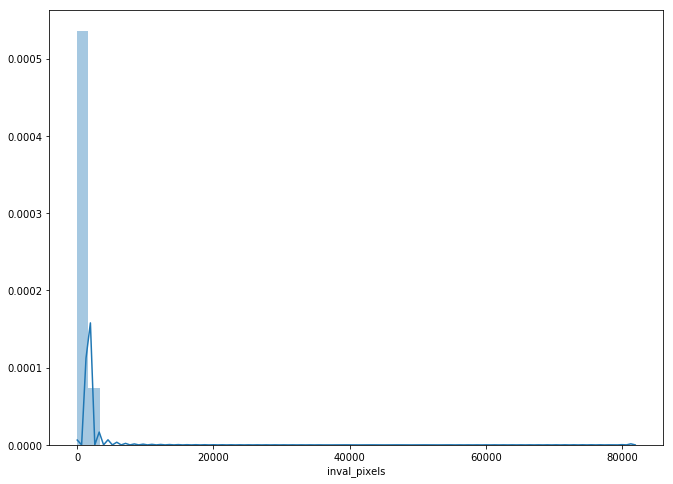

In [7]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(df['inval_pixels'], ax=ax)

In [8]:
# Percentage that have no invalid pixels
pnt_no_invals = df[df['inval_pixels'] == 0]['filename'].count()/df['filename'].count()*100
print('Percentage of Images with No Invalid Pixels: {:.2f}%'.format(pnt_no_invals))

Percentage of Images with No Invalid Pixels: 77.81%


Below are some quick summary stats for the ~24% of patches with at least one invalid pixel

In [9]:
w_invals = df[df['inval_pixels'] > 0]
w_invals.describe()

,patch_no,inval_pixels,fraction_invalid
count,343379.000000,343379.000000,343379.000000
mean,58.318610,1174.281855,0.011933
std,38.351666,1406.485436,0.014293
min,0.000000,1.000000,0.000010
25%,25.000000,60.000000,0.000610
50%,54.000000,1664.000000,0.016910
75%,88.000000,1664.000000,0.016910
max,149.000000,81920.000000,0.832495


## Let's check this out by date too
(as available through the file name)

In [10]:
by_date = df.groupby(df['filename'].str.slice(start=10, stop=14)) \
                 .agg({'patch_no': 'count', 'inval_pixels':'mean'}).reset_index() \
                 .rename(columns={'inval_pixels': 'avg_invalid_pixels', 'patch_no': 'patch_count'})
by_date.head()

,filename,patch_count,avg_invalid_pixels
0,2000,15888,18.488922
1,2001,49111,26.803995
2,2002,33623,28.442316
3,2003,73158,23.454017
4,2004,100399,26.003785


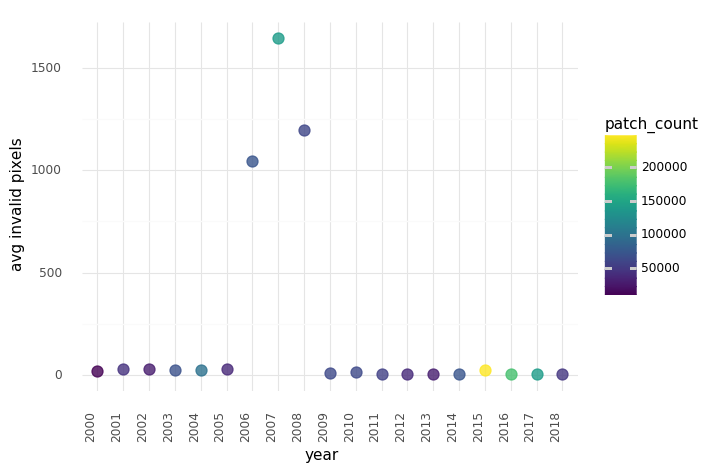

<ggplot: (-9223372036549944383)>

In [11]:
p9.ggplot(data=by_date, mapping=p9.aes(x='filename', y='avg_invalid_pixels')) \
          + p9.geom_point(p9.aes(color='patch_count'),  size=4, alpha=0.8) + p9.theme_minimal() \
          + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)) + p9.labels.xlab('year') \
          + p9.labels.ylab('avg invalid pixels')

In [12]:
df['year'] = df['filename'].str.slice(start=10, stop=14)
df['day'] = df['filename'].str.slice(start=14, stop=17)

In [29]:
df.groupby(['year', 'day']).agg({'patch_no': 'count', 'inval_pixels':'sum'}).reset_index().head()

,year,day,patch_no,inval_pixels
0,2000,260,15888,293752
1,2001,015,12503,216198
2,2001,162,12751,333803
3,2001,196,8728,355960
4,2001,226,7977,206055


## Quick Summary Stats

In [14]:
grouped.describe()

,patch_count,sum_invalid_pixels
count,14511.000000,1.451100e+04
mean,106.638964,2.778745e+04
std,44.733943,8.019884e+04
min,1.000000,0.000000e+00
25%,79.000000,0.000000e+00
50%,112.000000,1.200000e+01
75%,137.000000,1.021000e+03
max,450.000000,5.216359e+06


Correlation Quick Check

In [15]:
grouped.corr()

,patch_count,sum_invalid_pixels
patch_count,1.000000,0.108862
sum_invalid_pixels,0.108862,1.000000


Percentage with No Invalid Pixels

In [16]:
# Percentage that have no invalid pixels
pnt_no_invals = grouped[grouped['sum_invalid_pixels'] == 0]['filename'].count()/grouped['filename'].count()*100
print('Percentage of Images with No Invalid Pixels: {:.2f}%'.format(pnt_no_invals))

Percentage of Images with No Invalid Pixels: 31.00%


## Distribution Plots

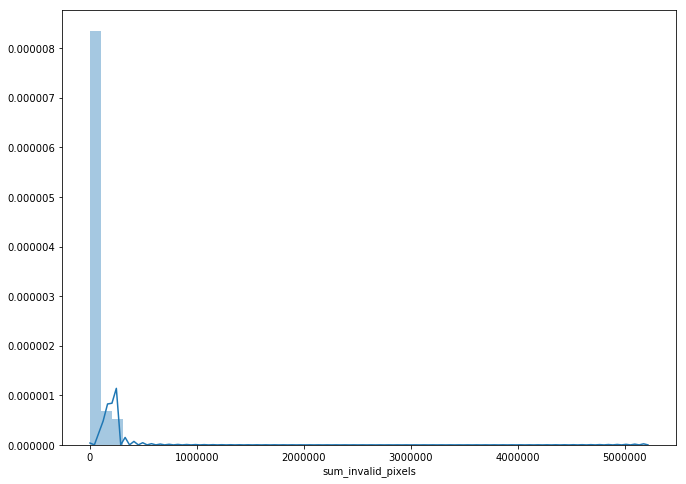

In [17]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(grouped['sum_invalid_pixels'], ax=ax)

In [18]:
def create_scatter(df, col1='sum_invalid_pixels', col2='patch_count'):
    '''
    Creates a scatterplot of distribution
    
    Inputs:
        df: a pandas dataframe
        col1(str): a column in the pandas dataframe
        col2(str): another column in the pandas dataframe

    Outputs: plotnine (ggplot) scatterplot
    '''
    p = p9.ggplot(data=df, mapping=p9.aes(x=col1, y=col2)) \
                  + p9.geom_point(alpha=0.3, color='blue') + p9.theme_minimal() \
                  + p9.ggtitle('Distribution of the No. of Invalid Pixels by No. Patches for Each Image')
    return p

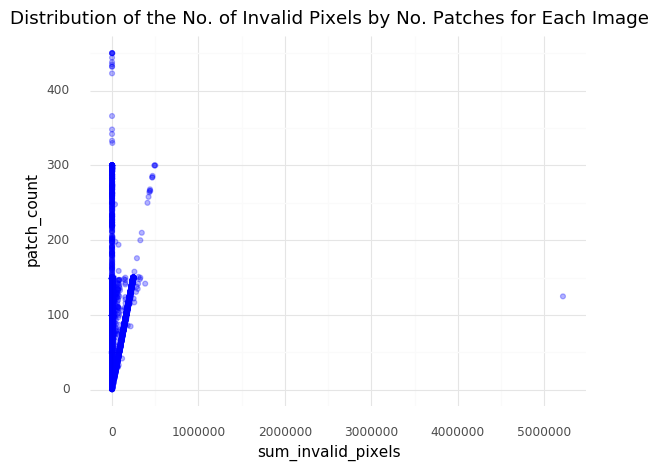

<ggplot: (329463830)>

In [19]:
create_scatter(grouped)

This is good! 1.) Many full images have no invalid pixels. 2.) B/c patches same size and assumption that invalid pixels randomly (and equally) distributed, the plot confirms that as patch count increases, the total number of invalid pixels increases for a given image (as expected)

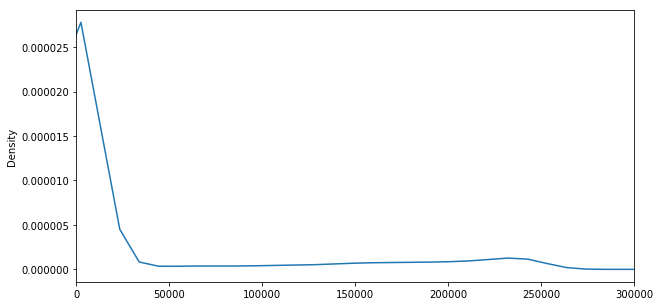

In [20]:
grouped['sum_invalid_pixels'].plot(kind='kde', xlim=(0, 300000), figsize=(10, 5))

To plot both no. invalid pixels & no. patches on same axis, we need to scale

In [21]:
def scale_and_plot_kde(df, col1='sum_invalid_pixels', col2='patch_count',
                       col3='scaled_total_invalid_pixels', col4='scaled_patch_ct'):
    '''
    Scales two columns of a dataframe to floats between 0 and 100 and plots a kernel
    density estimation of the scaled columns
    
    Inputs:
        df: a pandas dataframe
        col1(str): column in dataframe of numbers
        col2(str): column in dataframe of numbers
        col3(str): name for new scaled column of col1
        col4(str): name for new scaled column of col2
    
    Outputs: None (prints a kde)
    '''
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
    df[col3] = min_max_scaler.fit_transform(df[[col1]])
    df[col4] = min_max_scaler.fit_transform(df[[col2]])
    df[[col3, col4]].plot(kind='kde', xlim=(0, 100), figsize=(10, 5))

/Users/katykoeing/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/katykoeing/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


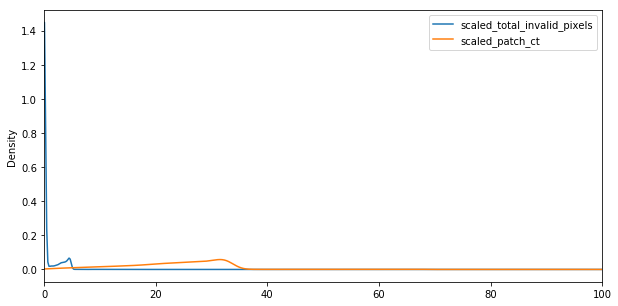

In [22]:
scale_and_plot_kde(grouped)

## Distribution by Date

Below, I use the slice from the filename that represents the year & how many days into the year the image was taken

In [23]:
by_date = grouped.groupby(grouped['filename'].str.slice(start=10, stop=17)) \
                 .agg({'patch_count': 'count', 'sum_invalid_pixels':'sum'}).reset_index()
by_date.head()

,filename,patch_count,sum_invalid_pixels
0,2000260,147,293752
1,2001015,123,216198
2,2001162,124,333803
3,2001196,90,355960
4,2001226,76,206055


### Again, quick summary stats

In [24]:
by_date.describe()

,patch_count,sum_invalid_pixels
count,141.000000,1.410000e+02
mean,102.914894,2.859743e+06
std,39.406941,7.921843e+06
min,38.000000,7.990000e+03
25%,68.000000,3.970900e+04
50%,84.000000,7.300600e+04
75%,148.000000,2.161980e+05
max,155.000000,2.746341e+07


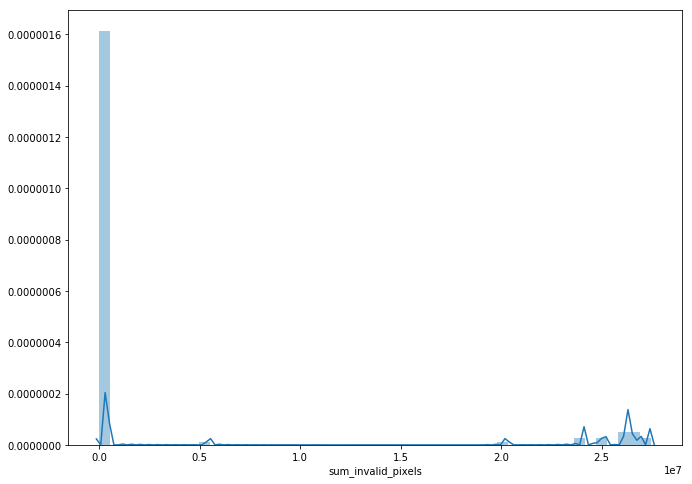

In [25]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(by_date['sum_invalid_pixels'], ax=ax)

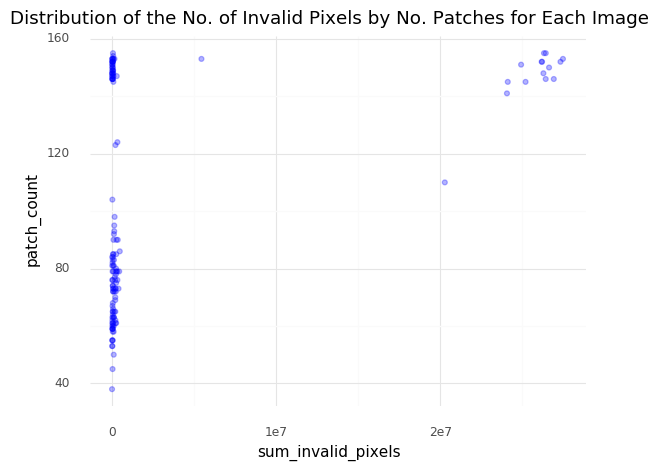

<ggplot: (329528787)>

In [26]:
create_scatter(by_date)

/Users/katykoeing/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/katykoeing/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


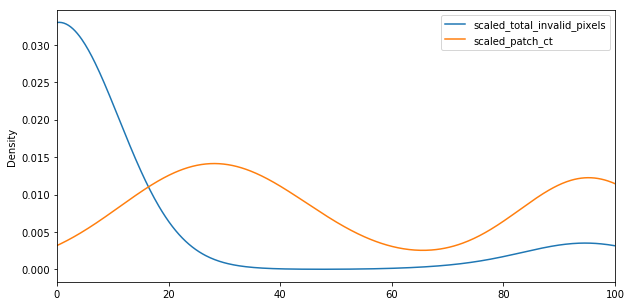

In [27]:
scale_and_plot_kde(by_date)

## Link MOD03 to MOD02 for geolocation data of pixels

In [39]:
mod02_file = 'MOD021KM.A2008112.1235.061.2017255220513.hdf'
fillvalue_list, mod02_img = stats.gen_mod02_img(mod02_file)
mod02_patches = _gen_patches(mod02_img, normalization=False)

mod03_file = 'MOD03.A2008112.1235.061.2017255095326.hdf'
mod03_hdf = SD(mod02_file, SDC.READ)
lat = mod03_hdf.select('Latitude')
latitude = lat[:,:]
lon = mod03_hdf.select('Longitude')
longitude = lon[:,:]

To do:
* map of world plot lat/long of bad pixels -- is in a certain area?
* blick of bad pixel patches vs. non-bad pixel patches
    *(ex: is it too bright? how are the bad pixels distributed in space? mean brightness? fraction of bad pixels per patch
* timeseries of fraction of bad data